In [1]:
import pandas as pd
# import gspread
import numpy as np
# from oauth2client.service_account import ServiceAccountCredentials
from IPython.display import Markdown as md
import seaborn as sns

In [2]:
# scope = ['https://spreadsheets.google.com/feeds']
# credentials = ServiceAccountCredentials.from_json_keyfile_name(
#     'swimming-winter-nationals-100d3d7fd304.json',
#     scope)
# gc = gspread.authorize(credentials)


# def get_table(spreadsheet_key: str) -> pd.DataFrame:
#     book = gc.open_by_key(spreadsheet_key)
#     worksheet = book.worksheet("Candidate Data")
#     return worksheet.get_all_values()

# table = get_table("1eYDBgZR9z1uSu6mwrRkcSm3ZWkOygDbWduQhc-fh5UY")

In [26]:
swimmer_name, race_name = "Omer", "100 bk"

sns.set_style("whitegrid")
sns.set_palette('Greens_d')

window_size = 4
md(f"{swimmer_name} - {race_name}\n=====")


Omer - 100 bk
=====

In [11]:
%%capture --no-stderr

import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from bisect import bisect


table = pd.read_csv("local_data/omer-100-bk-emek-hefer.csv")

def smooth(s: np.array, win_size: int) -> np.array:
    return pd.Series(s) \
        .rolling(window=win_size, step=win_size) \
        .mean()


def split_indices(intervals: pd.Series, splits: pd.Series) -> pd.Series:
    """
    Returns the indices of the intervals, that belongs to a specific split.
    That is if a[i] = k, it means that k is the smalles index for which
    sum(interval[:k]) >= splits[i].
    """
    min_cycle_time = 0.9
    total_time = splits.iat[-1] + 1e-3
    ret = np.array([])
    split_idx = 0
    # Adjust measurement drifts (we're all human).
    sums = [s for s in intervals.cumsum() if s <= total_time]
    last_cycle = total_time - sums[-1]
    if last_cycle < min_cycle_time:
        # Not enough time for another stroke, coalese the reminder.
        sums[-1] = total_time
    else:
        # Add an "artificial" last stroke.
        sums.append(total_time)
    for idx, v in enumerate(sums):
        if v < splits[split_idx]:
            continue
        ret = np.append(ret, idx)
        split_idx += 1
    return pd.Series(ret.astype(np.int32))


def label_plot_cont(time_intervals: pd.Series,
                    time_labels: pd.Series,
                    ax: plt.Axes) -> None:
    # if len(time_intervals) < len(time_labels):
    #     # This can happen, when the first 15m were all under water.
    #     time_labels = time_labels[1:]
    # print(time_intervals)
    # print(time_labels)
    assert len(time_intervals) == len(time_labels), \
        "#of labels and ticks should be identical"
    distances = [f"{int(d)}" for d in time_labels]
    ax.set_xticks(time_intervals)
    ax.set_xticklabels(distances, rotation=45)
    ax.set_title("Frequency for distance (continuous)")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Cycles/min.")
    
    
def label_plot_agg(bins: pd.Series,
                   splits: pd.Series,
                   ax: plt.Axes) -> None:
    labels = []
    b = 0 
    for bin in bins:
        e = int(splits[2 * bin + 1])
        labels.append(f"{b}-{e}")
        b = e
    
    ax.set_xticklabels(labels, rotation=45)
    ax.set_title("frequency for distance (averages)")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Cycles/min.")
    ax.bar_label(ax.containers[0], label="Frequency")
    
    
def adjust_lims(s: pd.Series, ax: plt.Axes) -> None:
    std, mean = np.std(s), np.mean(s)
    ax.set_ylim(bottom=mean-4*std, top=mean + (4 * std))
    rlimit = s.index[-1] + window_size
    ax.set_xlim(left=0, right=rlimit)
    
    
def __non_nan_column(df: pd.DataFrame, col: str) -> pd.Series:
    return df[~np.isnan(df[col])][col]


def __binning(t_intervals: pd.Series, frequencies: pd.Series) -> pd.Series:
    "Build the index for the sampling points, twice each lap."
    # print(f"time intervals: {t_intervals}")
    sample_points = [sp for
                     sp in
                     t_intervals.rolling(window=2, step=2, min_periods=2) \
        .max() \
        .shift(periods=-1, fill_value=t_intervals.iat[-1])]
    indices = [i for i in frequencies.index]
    bin_indices = [bisect(sample_points, idx)
                   for idx
                   in indices]
    return pd.Series([min(idx, len(sample_points)-1) for idx in bin_indices])
        

def frequency(df: pd.DataFrame) -> None:
    # display(df)
    cycle_indices = df["measurement"] == "cycle"
    time_intervals = split_indices(df["interval-time"],
                                   __non_nan_column(df, "split-time"))
    frequencies = 60 / df[cycle_indices]["interval-time"]

    # print(frequencies)
    # Build the (smoothed) continuous series.
    smoothed = smooth(frequencies.values, win_size=window_size)
    smoothed = smoothed.shift(periods=-1, fill_value=smoothed.iat[-1])
    
    # Build the aggregated series.
    bins = __binning(time_intervals, frequencies)
    df_continuous = pd.DataFrame({"Frequency": smoothed, "bin": bins})
    
    # Display cont.
    fig, axs = plt.subplots(ncols=2, figsize=(18, 6))
    # sns.lineplot(data=df_continuous.reindex(), x=df_continuous.index, y="Frequency", ax=axs[0])
    sns.lineplot(x=df_continuous.index, y=df_continuous["Frequency"], ax=axs[0])
    # Padding. if the uw is all the 15m - the bin will be empty.
    split_distances = __non_nan_column(df, "split-distance")
    # time_intervals = np.pad(time_intervals,
    #                         (len(split_distances) - len(time_intervals), 0),
    #                         "constant",
    #                         constant_values=0)
    label_plot_cont(time_intervals,
                    split_distances,
                    axs[0])
    adjust_lims(smoothed, axs[0])
    
    # Display aggregated.
    df_grouped = df_continuous \
        .groupby("bin", as_index=False)[["bin", "Frequency"]] \
        .mean()
    # Replace NaN values with mean. (TODO: get to the bottom of this..)
    fill_value = 35.0
    nan_indices = np.isnan(df_grouped["Frequency"])
    df_grouped["Frequency"][nan_indices] = fill_value
    df_grouped["Frequency"] = df_grouped["Frequency"].astype(int)
    
    sns.barplot(x="bin", y="Frequency", data=df_grouped, estimator="mean", ax=axs[1])
    label_plot_agg(df_grouped["bin"],
                   __non_nan_column(df, "split-distance"),
                   axs[1])

# Frequency

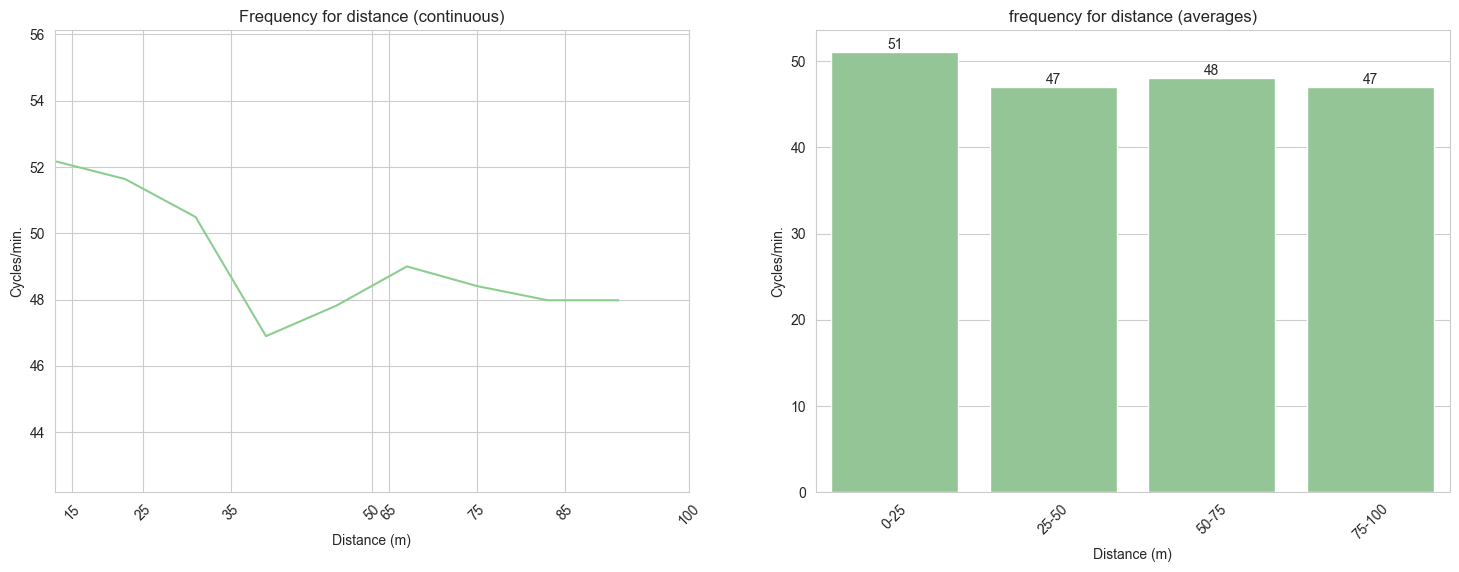

In [12]:
# %capture --no-stderr
import warnings
warnings.filterwarnings('ignore')
frequency(table)

In [13]:
import matplotlib.pyplot as plt


def __sc_labels(split_labels: pd.Series,
                ax: plt.Axes) -> None:
    labels = [int(split_labels[i])
              for i
              in split_labels.index
              if (i % 4) == 3]
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("# Strokes")
    ax.set_title("Number of strokes")
    ax.figure.set_size_inches((12, 3))


def num_strokes(df: pd.DataFrame, ax: plt.Axes) -> None:
    stroke_counts = df[~df["stroke-count"].isna()]["stroke-count"]
    sns.barplot(x=stroke_counts.index, y=stroke_counts.values)
    __sc_labels(__non_nan_column(df, "split-distance"), ax)
    ax.bar_label(ax.containers[0], label="#strokes")
 

# Cycles Count

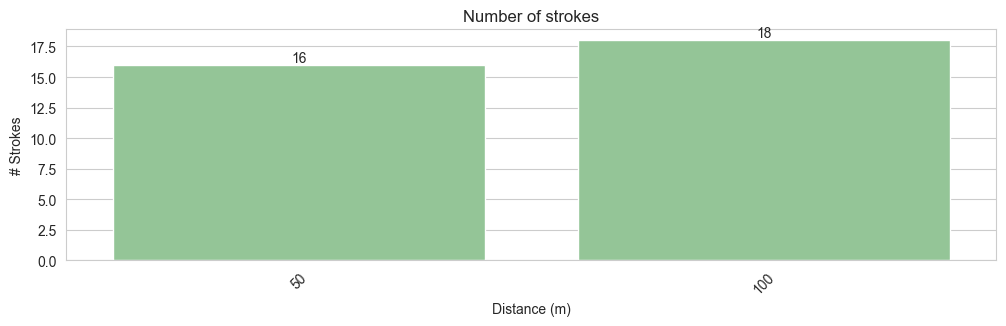

In [14]:

num_strokes(table, plt.axes())

# Splits

In [15]:
def format_seconds(seconds: float) -> str:
    if seconds < 60.0:
        return str(seconds)
    # Convert seconds to minutes and seconds
    minutes, seconds = divmod(seconds, 60)
    # Extract the whole number part of seconds (tenths of seconds)
    whole_seconds = int(seconds)
    tens_s = int(round(seconds-whole_seconds, 2) * 100)
    # Format the output string
    return f"{int(minutes)}:{whole_seconds:02}.{tens_s}"

    
valid_indices = (~np.isnan(table["split-distance"])) & (~np.isnan(table["split-time"]))
split_dist = table["split-distance"][valid_indices].astype(int)
split_times = [format_seconds(t) for t in table["split-time"][valid_indices].round(2)]
# display(pd.DataFrame({"Distance": split_dist, "Time": split_times}))

# Speed

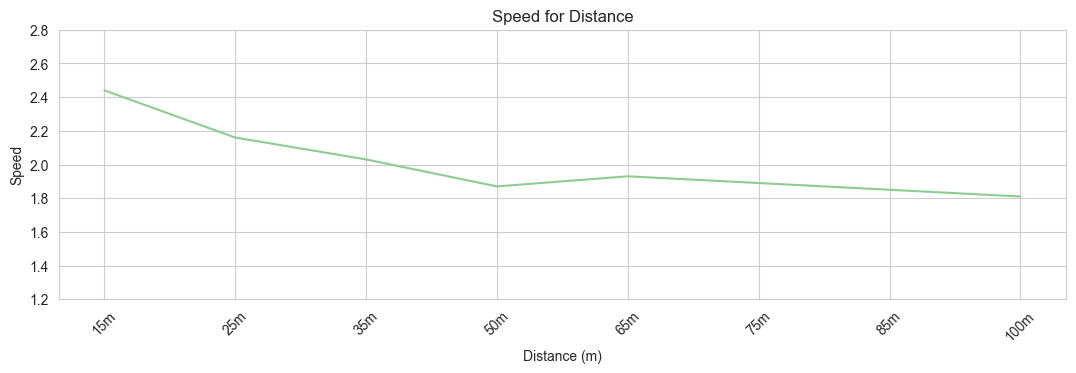

In [16]:
def __speed_labels(distances: pd.Series, ax: plt.Axes) -> None:
    labels = [f"{int(d)}m" for d in distances.values]
    ax.set_xticks(distances.index)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Speed")
    ax.set_title("Speed for Distance")
    ax.set_ylim(bottom=1.2, top=2.8)
    ax.figure.set_size_inches((13, 3.5))
    
    
def speed(df: pd.DataFrame) -> pd.DataFrame:
    distances = __non_nan_column(df, "split-distance")
    df_speed = pd.DataFrame(
        {"distance": distances,
         "time": __non_nan_column(df, "split-time")})
    df_speed["speed"] = (df_speed["distance"] / \
        df_speed["time"]).round(decimals=2)
    ax = plt.axes()
    sns.lineplot(x=df_speed.index, y=df_speed.speed)
    __speed_labels(df_speed["distance"], ax)
    

speed(table)

# Splits

In [25]:
valid_indices = ~table["split-distance"].isna()
display(table[valid_indices][["split-distance", "split-time"]])

,split-distance,split-time
0,15.0,6.14
1,25.0,11.60
2,35.0,17.28
3,50.0,26.67
4,65.0,33.75
5,75.0,39.70
6,85.0,45.86
7,100.0,55.37
